In [1]:
# Install necessary libraries
! pip install -U transformers safetensors matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.9 MB/s eta 0:00:00


In [2]:
import torch

In [3]:
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
  DEVICE = "cuda"
  print(f"Using {DEVICE}")
else:
  DEVICE = "cpu"
  print(f"Using {DEVICE}")

Using cuda


In [4]:
# Display GPU information
! nvidia-smi

Mon Jun 16 18:48:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
from transformers import AutoModelForCausalLM
from safetensors import safe_open
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# Define the model ID and load the model
model_id = "HuggingFaceTB/SmolLM2-135M"
model = AutoModelForCausalLM.from_pretrained(model_id).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [7]:
# Save the model and define the path to the safetensors file
model.save_pretrained("./Model/")

safetensors_file = "./Model/model.safetensors"

In [8]:
with safe_open(safetensors_file, framework="pt", device=DEVICE) as f:
    # Get all tensor names
    tensor_names = f.keys()
    print("Available tensors:", len(tensor_names))

    # Load specific tensor
    tensor = f.get_tensor(tensor_names[0])
    print(f"{tensor_names[0]}: {tensor.shape}, dtype: {tensor.dtype}")

    # Show the actual weight values
    print(f"First few values:\n{tensor.flatten()[:10]}")

    # Statistical analysis
    print(f"\n📈 Statistical Properties:")
    print(f"   Mean: {tensor.mean().item():.6f}")
    print(f"   Std Dev: {tensor.std().item():.6f}")
    print(f"   Min: {tensor.min().item():.6f}")
    print(f"   Max: {tensor.max().item():.6f}")

Available tensors: 272
model.embed_tokens.weight: torch.Size([49152, 576]), dtype: torch.float32
First few values:
tensor([-0.1177,  0.0278,  0.0481, -0.0079, -0.0562, -0.0520,  0.0165, -0.1338,
         0.1079, -0.2295], device='cuda:0')

📈 Statistical Properties:
   Mean: -0.000520
   Std Dev: 0.134662
   Min: -1.984375
   Max: 1.882812


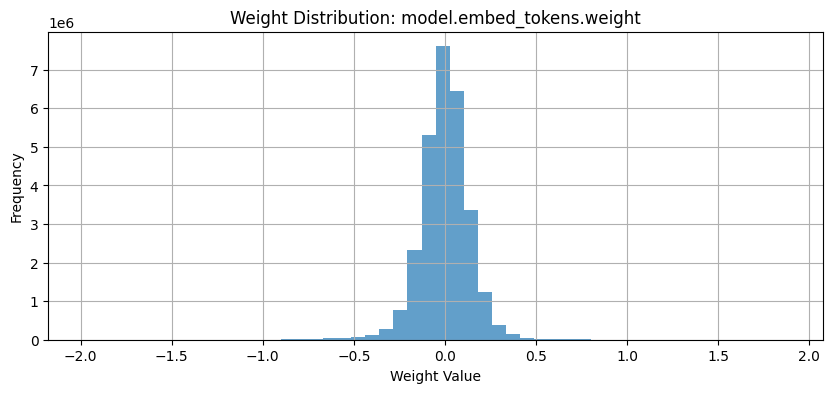

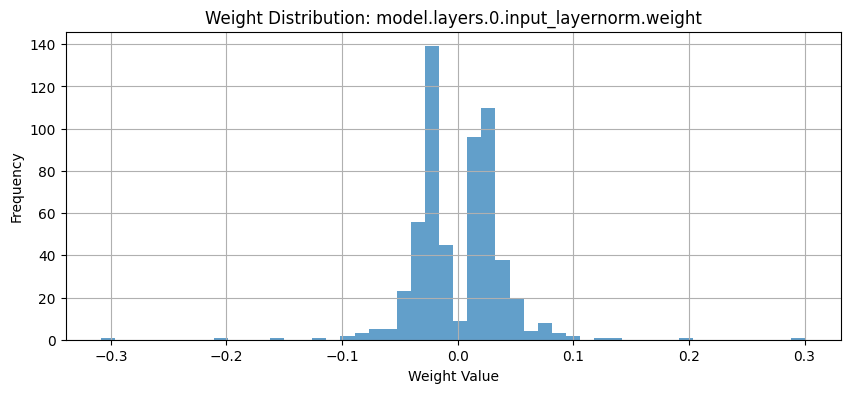

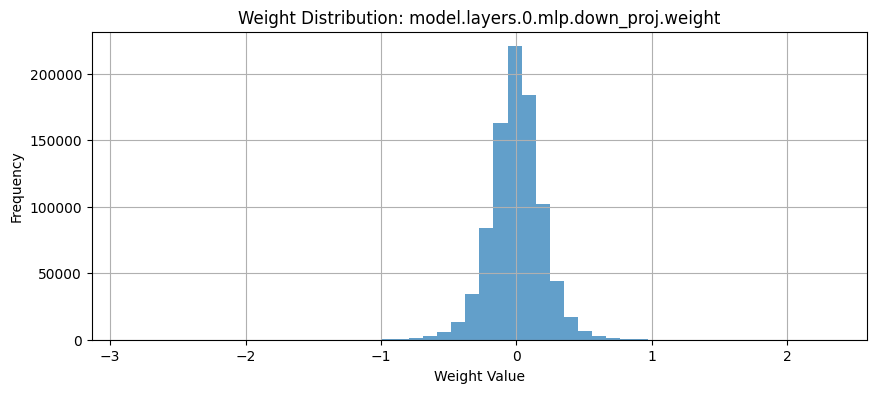

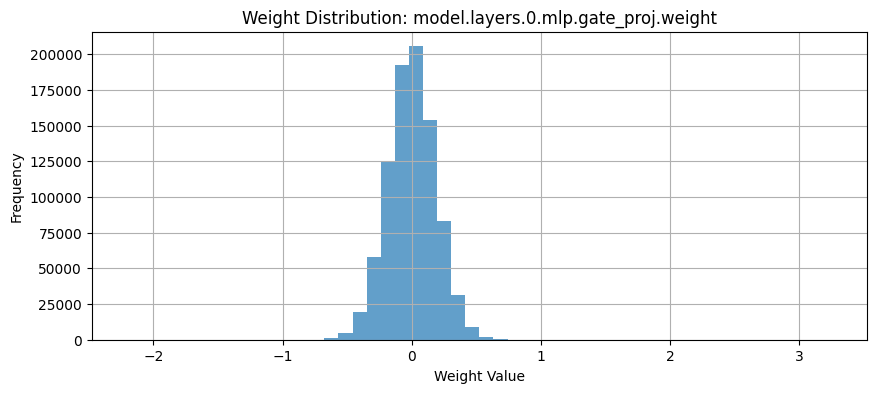

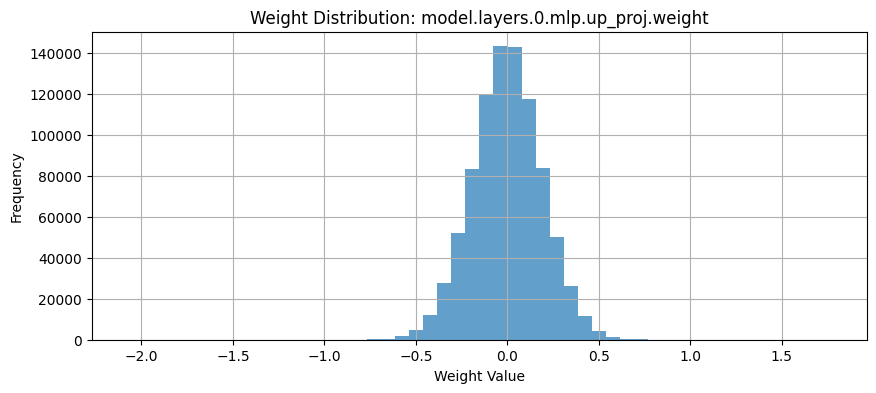

In [9]:
# Weight Histogram

with safe_open(safetensors_file, framework="pt", device=DEVICE) as f:
    for name in list(f.keys())[:5]:  # First 5 layers
        # Load tensor to GPU
        weights = f.get_tensor(name)

        # Move to CPU for numpy conversion and plotting
        weights_cpu = weights.cpu().numpy().flatten()

        plt.figure(figsize=(10, 4))
        plt.hist(weights_cpu, bins=50, alpha=0.7)
        plt.title(f"Weight Distribution: {name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

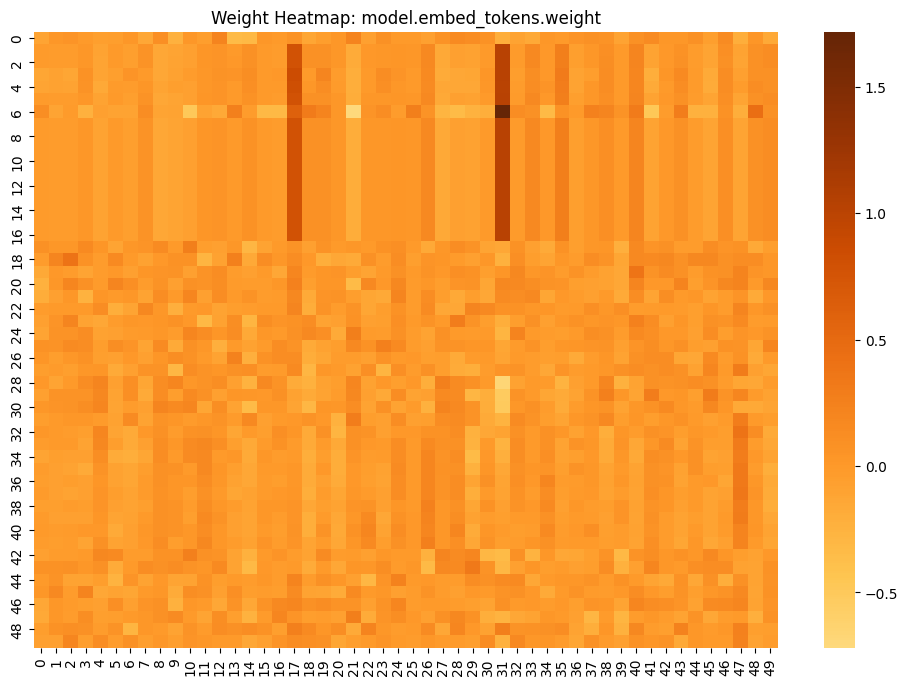

In [10]:
# Heatmap

with safe_open(safetensors_file, framework="pt", device=DEVICE) as f:
    for name in f.keys():
        tensor = f.get_tensor(name)
        if len(tensor.shape) == 2:  # 2D matrices
            plt.figure(figsize=(12, 8))
            sns.heatmap(tensor.cpu().numpy()[:50, :50], cmap='YlOrBr', center=0)
            plt.title(f"Weight Heatmap: {name}")
            plt.show()
            break  # Show first 2D tensor found

<ipython-input-11-3109554763>:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=layer_names, vert=False, patch_artist=True)


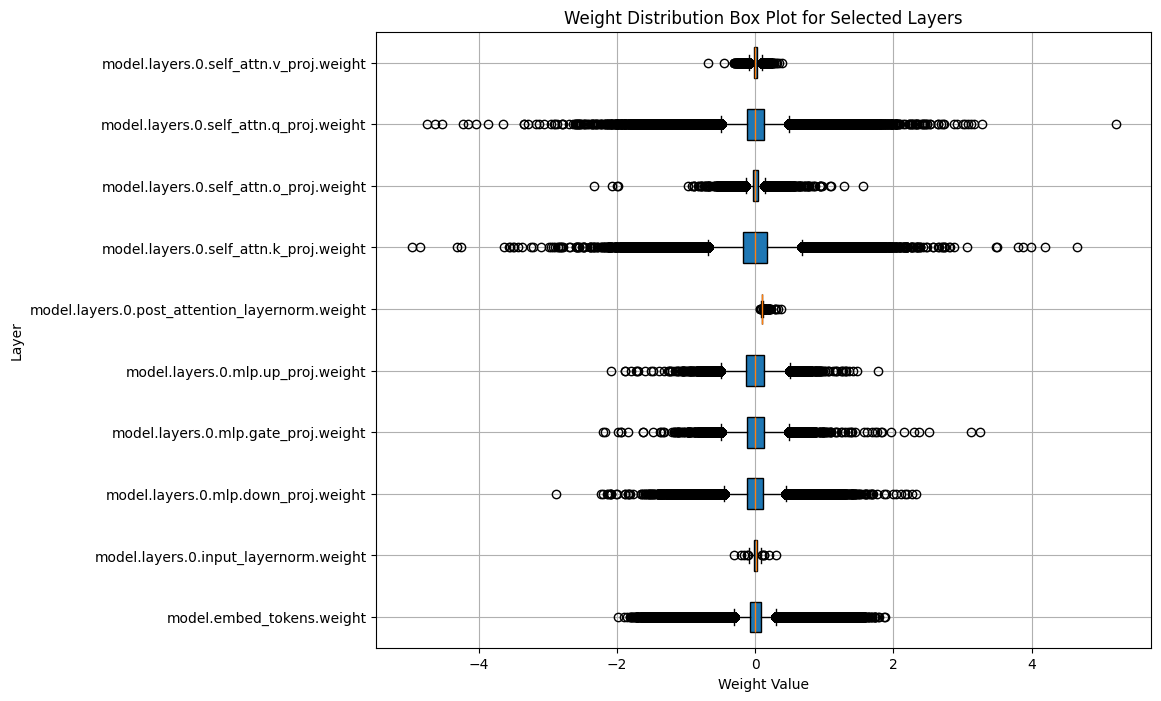

In [11]:
# Box Plot

with safe_open(safetensors_file, framework="pt", device=DEVICE) as f:
    data_to_plot = []
    layer_names = []
    # Select a few layers for the box plot to keep it manageable
    for i, name in enumerate(list(f.keys())[:10]): # Plotting first 10 layers for demonstration
        tensor = f.get_tensor(name)
        # Move to CPU for numpy conversion
        weights_cpu = tensor.cpu().numpy().flatten()
        data_to_plot.append(weights_cpu)
        layer_names.append(name)

    plt.figure(figsize=(10, 8))
    plt.boxplot(data_to_plot, labels=layer_names, vert=False, patch_artist=True)
    plt.title("Weight Distribution Box Plot for Selected Layers")
    plt.xlabel("Weight Value")
    plt.ylabel("Layer")
    plt.grid(True)
    plt.show()